<a href="https://www.kaggle.com/code/vanpatangan/supply-chain-in-healthcare?scriptVersionId=202433174" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load datasets
inventory_df = pd.read_csv('/kaggle/input/hospital-supply-chain/inventory_data.csv')
patient_df = pd.read_csv('/kaggle/input/hospital-supply-chain/patient_data.csv')
staff_df = pd.read_csv('/kaggle/input/hospital-supply-chain/staff_data.csv')
financial_df = pd.read_csv('/kaggle/input/hospital-supply-chain/financial_data.csv')

sns.set_theme(style="whitegrid", palette="pastel")

# Data Summary

In [ ]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [ ]:
print("Inventory Data Summary")
display(check(inventory_df))
display(inventory_df.head())
print("Patient Data Summary")
display(check(patient_df))
display(patient_df.head())
print("Staff Data Summary")
display(check(staff_df))
display(staff_df.head())
print("Financial Data Summary")
display(check(financial_df))
display(financial_df.head())

In [2]:
# Rename Date columns for distinction
inventory_df = inventory_df.rename(columns={'Date': 'Inventory_Date'})
financial_df = financial_df.rename(columns={'Date': 'Financial_Date'})

# Convert date columns to datetime
inventory_df['Inventory_Date'] = pd.to_datetime(inventory_df['Inventory_Date'])
patient_df['Admission_Date'] = pd.to_datetime(patient_df['Admission_Date'])
patient_df['Discharge_Date'] = pd.to_datetime(patient_df['Discharge_Date'])
staff_df['Shift_Date'] = pd.to_datetime(staff_df['Shift_Date'])
financial_df['Financial_Date'] = pd.to_datetime(financial_df['Financial_Date'])

# Combine dataframes
combined_df = pd.concat([inventory_df, patient_df, staff_df, financial_df], axis=1)
combined_df.fillna(0, inplace=True)  # Fill NaNs with 0

#combined_df.head()

# EDA

## Stock Level Trends Over Time
**Plot the trends in stock levels for selected supplies over time.**

In [ ]:
# Select a few key supplies for visualization
key_supplies = combined_df[combined_df['Item_Name'].isin(['Surgical Mask', 'Gloves', 'IV Drip'])]

plt.figure(figsize=(12, 4))
sns.lineplot(x='Inventory_Date', y='Current_Stock', hue='Item_Name', data=key_supplies)
plt.title('Stock Level Trends Over Time for Key Supplies')
plt.xlabel('Date')
plt.ylabel('Stock Level')
plt.xticks(rotation=45)
plt.show()

## Analyze Stock Levels vs. Demand
**Visualize how long the hospital's current stock of supplies will last based on average daily usage.**

In [ ]:
combined_df['Days_Stock_Last'] = combined_df['Current_Stock'] / combined_df['Avg_Usage_Per_Day']

# Visualize supplies that are expected to last less than 7 days
low_stock_items = combined_df[combined_df['Days_Stock_Last'] < 7]

plt.figure(figsize=(12, 4))
sns.barplot(x='Item_Name', y='Days_Stock_Last', data=low_stock_items)
plt.title('Supplies Expected to Last Less Than 7 Days')
plt.xticks(rotation=45)
plt.ylabel('Days Stock Will Last')
plt.show()

💡Surgical Masks have the shortest expected duration

## Equipment Utilization by Patients
**Which equipment is used most frequently by patients.**

In [ ]:
equipment_usage = combined_df['Equipment_Used'].value_counts()

plt.figure(figsize=(12, 4))
equipment_usage.plot(kind='bar')
plt.title('Equipment Usage by Patients')
plt.xlabel('Equipment')
plt.ylabel('Number of Uses')
plt.xticks(rotation=45)
plt.show()

## Workload Distribution by Staff Assignment
**Show the average number of patients assigned to staff in different hospital areas.**

In [ ]:
plt.figure(figsize=(12, 4))
combined_df.groupby('Current_Assignment')['Patients_Assigned'].mean().plot(kind='bar', color='darksalmon')
plt.title('Average Patients Assigned per Staff by Department')
plt.ylabel('Average Patients')
plt.xticks(rotation=45)
plt.show()

## Overtime Hours by Staff Type
**Visualize average overtime hours worked by different types of staff.**

In [ ]:
overtime_by_staff = combined_df.groupby('Staff_Type')['Overtime_Hours'].mean()

plt.figure(figsize=(12, 4))
overtime_by_staff.plot(kind='bar', color='skyblue')
plt.title('Average Overtime Hours per Staff Type')
plt.ylabel('Overtime Hours')
plt.xticks(rotation=45)
plt.show()

## Expense Breakdown (Supplies, Equipment, Staffing)
**How financial resources are distributed among different expense categories.**

In [ ]:
plt.figure(figsize=(3, 3))
combined_df.groupby('Expense_Category')['Amount'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Expense Breakdown')
plt.ylabel('')
plt.show()

## Check for Unique Values
**If these ID columns represent unique identifiers,it is likely that they are not useful for correlation analysis or modeling.**


In [ ]:
print(f"Unique Staff_ID: {staff_df['Staff_ID'].nunique()}")
print(f"Unique Patient_ID: {patient_df['Patient_ID'].nunique()}")
print(f"Unique Vendor_ID: {inventory_df['Vendor_ID'].nunique()}")

## Feature Engineering

In [3]:
# Calculate Remaining Stock Percentage (Current Stock vs Max Capacity)
combined_df['Stock_Percentage'] = (combined_df['Current_Stock'] / combined_df['Max_Capacity']) * 100

# Calculate Days to Stockout (using Avg Usage Per Day)
combined_df['Days_To_Stockout'] = combined_df['Current_Stock'] / combined_df['Avg_Usage_Per_Day']

# Create a feature for how close stock is to the minimum required
combined_df['Below_Min_Stock'] = combined_df['Current_Stock'] < combined_df['Min_Required']

# Binary feature for whether or not a procedure was performed
combined_df['Procedure_Performed_Flag'] = combined_df['Procedure_Performed'].notnull()

# Interaction feature: Days spent by patients (i.e., Bed Days multiplied by Patients Assigned)
combined_df['Total_Bed_Days'] = combined_df['Bed_Days'] * combined_df['Patients_Assigned']


In [4]:
# Create a Target Variable
combined_df['Estimated_Demand'] = combined_df['Avg_Usage_Per_Day'] * combined_df['Restock_Lead_Time']

# Encoding

In [5]:
# List of object dtype columns for encoding
object_cols = ['Item_Type', 'Item_Name', 'Vendor_ID', 'Patient_ID', 'Primary_Diagnosis', 
               'Procedure_Performed', 'Room_Type', 'Supplies_Used', 'Equipment_Used', 
               'Staff_Needed', 'Staff_ID', 'Staff_Type', 'Current_Assignment', 
               'Shift_Start_Time', 'Shift_End_Time', 'Expense_Category', 'Description']

# One-hot encode the object dtype columns
combined_df_encoded = pd.get_dummies(combined_df, columns=object_cols)
combined_df_encoded.fillna(0, inplace=True)  # Fill NaNs with 0

In [7]:
combined_df_encoded.tail()

,Inventory_Date,Item_ID,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Admission_Date,Discharge_Date,...,Shift_End_Time_06:00 PM,Shift_End_Time_07:00 PM,Expense_Category_0,Expense_Category_Equipment,Expense_Category_Staffing,Expense_Category_Supplies,Description_0,Description_Surgeons' salaries,Description_Surgical masks,Description_Ventilators
45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-10-01 10:55:35,2024-10-12 14:47:19,...,True,False,True,False,False,False,True,False,False,False
46,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-10-18 02:50:04,2024-10-24 02:13:07,...,True,False,True,False,False,False,True,False,False,False
47,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-10-03 02:53:33,2024-10-20 23:02:01,...,True,False,True,False,False,False,True,False,False,False
48,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-10-27 04:12:58,2024-10-12 01:14:25,...,False,True,True,False,False,False,True,False,False,False
49,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024-10-12 12:59:32,2024-10-25 21:43:28,...,False,True,True,False,False,False,True,False,False,False


# Modeling

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Mean Absolute Error after tuning: 495.3928239279937


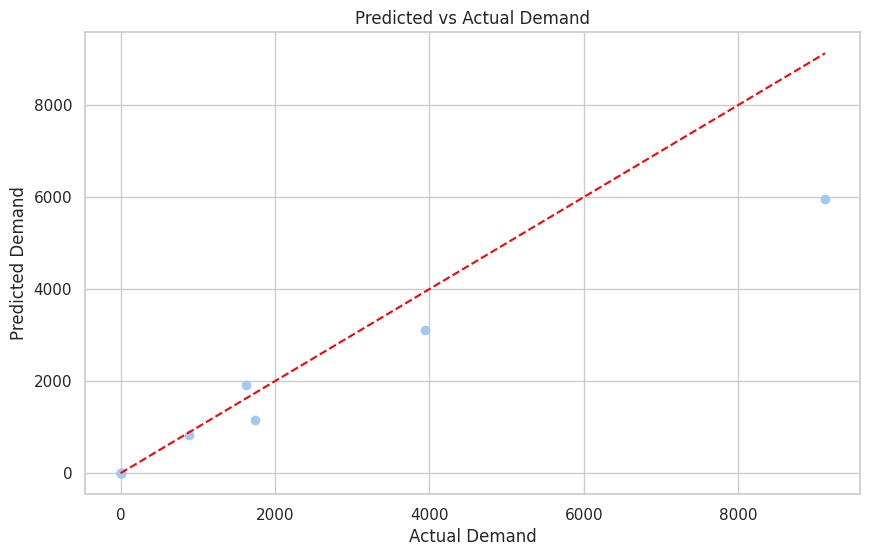

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


# Target variable
y = combined_df_encoded['Estimated_Demand']

# Drop target and non-relevant columns from the feature set
X = combined_df_encoded.drop(['Estimated_Demand', 'Inventory_Date', 'Admission_Date', 
                              'Discharge_Date', 'Shift_Date', 'Financial_Date'], axis=1)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

# Initialize the GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=-1, scoring='neg_mean_absolute_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error after tuning: {mae}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Predicted vs Actual Demand')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Target variable
y = combined_df_encoded['Estimated_Demand']

# Drop target and non-relevant columns from the feature set
X = combined_df_encoded.drop(['Estimated_Demand', 'Inventory_Date', 'Admission_Date', 
                              'Discharge_Date', 'Shift_Date', 'Financial_Date'], axis=1)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Predicted vs Actual Demand')
plt.show()
